In [37]:
import os
from nilearn import datasets, plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Generating the brain atlas
atlas = datasets.fetch_atlas_aal()
atlas_filename = atlas.maps
labels = atlas.labels

# Finding the coordinates of the brain segments
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)

# Making a dictionary out of the positions of the brain segments and the positions in MNI space
brain_segments_pos = {}
for idx, val in enumerate(atlas.labels):
    brain_segments_pos[val] = list(np.around(coordinates[idx],2))

In [5]:
# Here I start with the ADNI_full folder with the time_series folder already generated, so I only need to load the time series
def load_time_series():
    root = 'ADNI_full/time_series'
    time_series_list = os.listdir(root)
    time_series=[]
    for i in time_series_list:
        time_series_sub = np.loadtxt(os.path.join(root, i), delimiter=',')
        time_series.append(time_series_sub)
    return time_series

In [6]:
# Make the list of time series into a list of df
def time_series_to_df(time_series):
    df_time_series = []
    for i in time_series:
        df = pd.DataFrame(i)
        df_time_series.append(df)
    return df_time_series

In [38]:
# Defining the different correlation relations to build the correlation matrix.
# We also set the diagonal to 0 to avoid bias and the NaN values to 0.

def pearson_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='pearson').fillna(0)
        np.fill_diagonal(corr_df.values, 0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def spearman_rank_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='spearman').fillna(0)
        np.fill_diagonal(corr_df.values, 0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def kendall_rank_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='kendall').fillna(0)
        np.fill_diagonal(corr_df.values, 0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def partial_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='pearson').fillna(0)
        n = corr_df.shape[0]
        partial_corr_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                partial_corr_matrix[i, j] = -corr_df.iloc[i, j] / np.sqrt(corr_df.iloc[i, i] * corr_df.iloc[j, j])
        np.fill_diagonal(partial_corr_matrix, 1)
        corr_matrices.append(partial_corr_matrix)
    return corr_matrices

def distance_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        n = df.shape[1]
        distance_corr_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                dx = df.iloc[:, i] - df.iloc[:, i].mean()
                dy = df.iloc[:, j] - df.iloc[:, j].mean()
                distance_corr_matrix[i, j] = np.sqrt(np.dot(dx, dx) * np.dot(dy, dy)) / np.sqrt(np.dot(dx, dx) * np.dot(dy, dy))
                distance_corr_matrix[j, i] = distance_corr_matrix[i, j]
        np.fill_diagonal(distance_corr_matrix, 1)
        corr_matrices.append(distance_corr_matrix)
    return corr_matrices

# George's correlation function
def df_pcorr(df_time_series):
    corr_gsr = []
    for i in range(len(df_time_series)):
        df = pd.DataFrame(df_time_series[i])
        corr_df = df.corr(method='pearson')
        corr_arr = corr_df.to_numpy()
        corr_arr = np.nan_to_num(corr_arr, nan=0)
        np.fill_diagonal(corr_arr, 0)
        corr_gsr.append(corr_arr)
    return corr_gsr

In [32]:
# Plot the correlation matrix
def plot_corr(corr_matrix, method):
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(f'{method} Correlation Matrix')
    plt.show()

In [9]:
# Loading the time_series and building the df of time_series
time_series = load_time_series()
df_time_series = time_series_to_df(time_series)

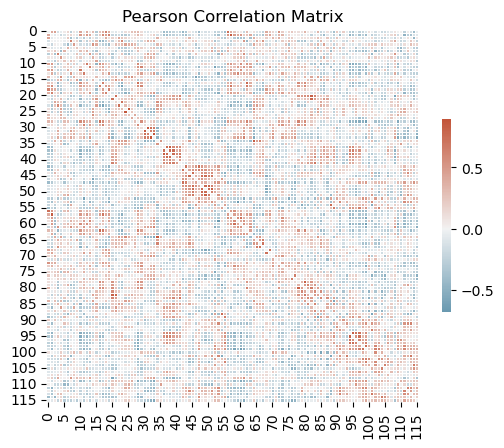

In [40]:
# Generating the correlation matrices
idx_patient = 20

# Using the pearson correlation function
corr_matrix_pearson = pearson_corr(df_time_series)
plot_corr(corr_matrix_pearson[idx_patient], 'Pearson')

# Using the spearman rank correlation function
corr_matrix = spearman_rank_corr(df_time_series)
plot_corr(corr_matrix[idx_patient], 'Spearman Rank')

# Using the kendall rank correlation function
corr_matrix = kendall_rank_corr(df_time_series)
plot_corr(corr_matrix[idx_patient], 'Kendall Rank')

# Using the partial correlation function
corr_matrix = partial_corr(df_time_series)
plot_corr(corr_matrix[idx_patient], 'Partial')

# Using the distance correlation function
corr_matrix = distance_corr(df_time_series)
plot_corr(corr_matrix[idx_patient], 'Distance')

# Using the George's correlation implementation function
corr_matrix_george = df_pcorr(df_time_series)
plot_corr(corr_matrix_george[idx_patient], 'George')